## Imports necessary for the code to work

In [10]:
from src import get_lethality_rate
import pandas as pd
%matplotlib notebook

## Loading the dateset
The dataset is loaded from [Our World in Data](https://ourworldindata.org/) [covid-19-data repository](https://github.com/owid/covid-19-data/).

In [2]:
data_path = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv'
data = pd.read_csv(data_path)
countries = data['location'].unique()

## Plotting examples

The function `get_lethality_rate` allows us to plot our dataset.

By default, this function plots some measurements of the lethality rate.
Here we compute the lethality rate as the number of people who died within a given time window of size $\delta d$ days divided by the number of people tested positive within the same time window of size $\delta d$ but $\delta d$ days before.

In other words, if $LR$ is our lethality rate then $LR=\frac{Death_{d, d+\delta d}}{Positive_{d-\delta d, d}}$ where $Death_{d, d+\delta d}$ is the number of death in between the days $d$ and the day being $\delta d$ days later: $d+\delta d$. And $Positive_{d-\delta d, d}$ is the number of positive people between the day $d$ and the day $\delta d$ before: $d-\delta d$.

Here we use value of $\delta d=18$ days, which is the average number of days to for a patient to die from corona (`death_delay` in the code).

The function can be parameterized. The following values can be changed to change the display (marginally or drastically).
- `country`: Which country to look at. The list of all countries available can be found by running the command `data['location'].unique()`. One can use `"World"` as a country to display the overall numbers.
- `additional_plots`: Allows adding plots to be displayed. In the following example will be plotted the number of new cases (`'new_cases`), the number of patient hospitalised (`'hosp_patients'`), the number of patients in intensive care unit (`'icu_patients'`) and the percentage of people vaccinated (`'people_vaccinated_per_hundred'`). The list of all possible plots is accessible by running the command `data.keys()`.
- `smoothing_size`: It is recommended to smooth the dataset, the amplitude of the smoothing is determined here by the `smoothing_size` parameter. Its unit is in days, meaning that in our following example where the `smoothing_size` is `7`, the smoothing is over a week.
- `death_delay`: $\delta d$ value mentioned earlier. Here we use a delay of 2 weeks
- `start`: it is possible to change the starting date from which to visualise the data. The value is expected as a string in the format 'yyyy-mm-dd'. If the value is put to `None` then the beginning of the dataset will be used.
- `end`: same as start but for the end of the plotting window.

<IPython.core.display.Javascript object>


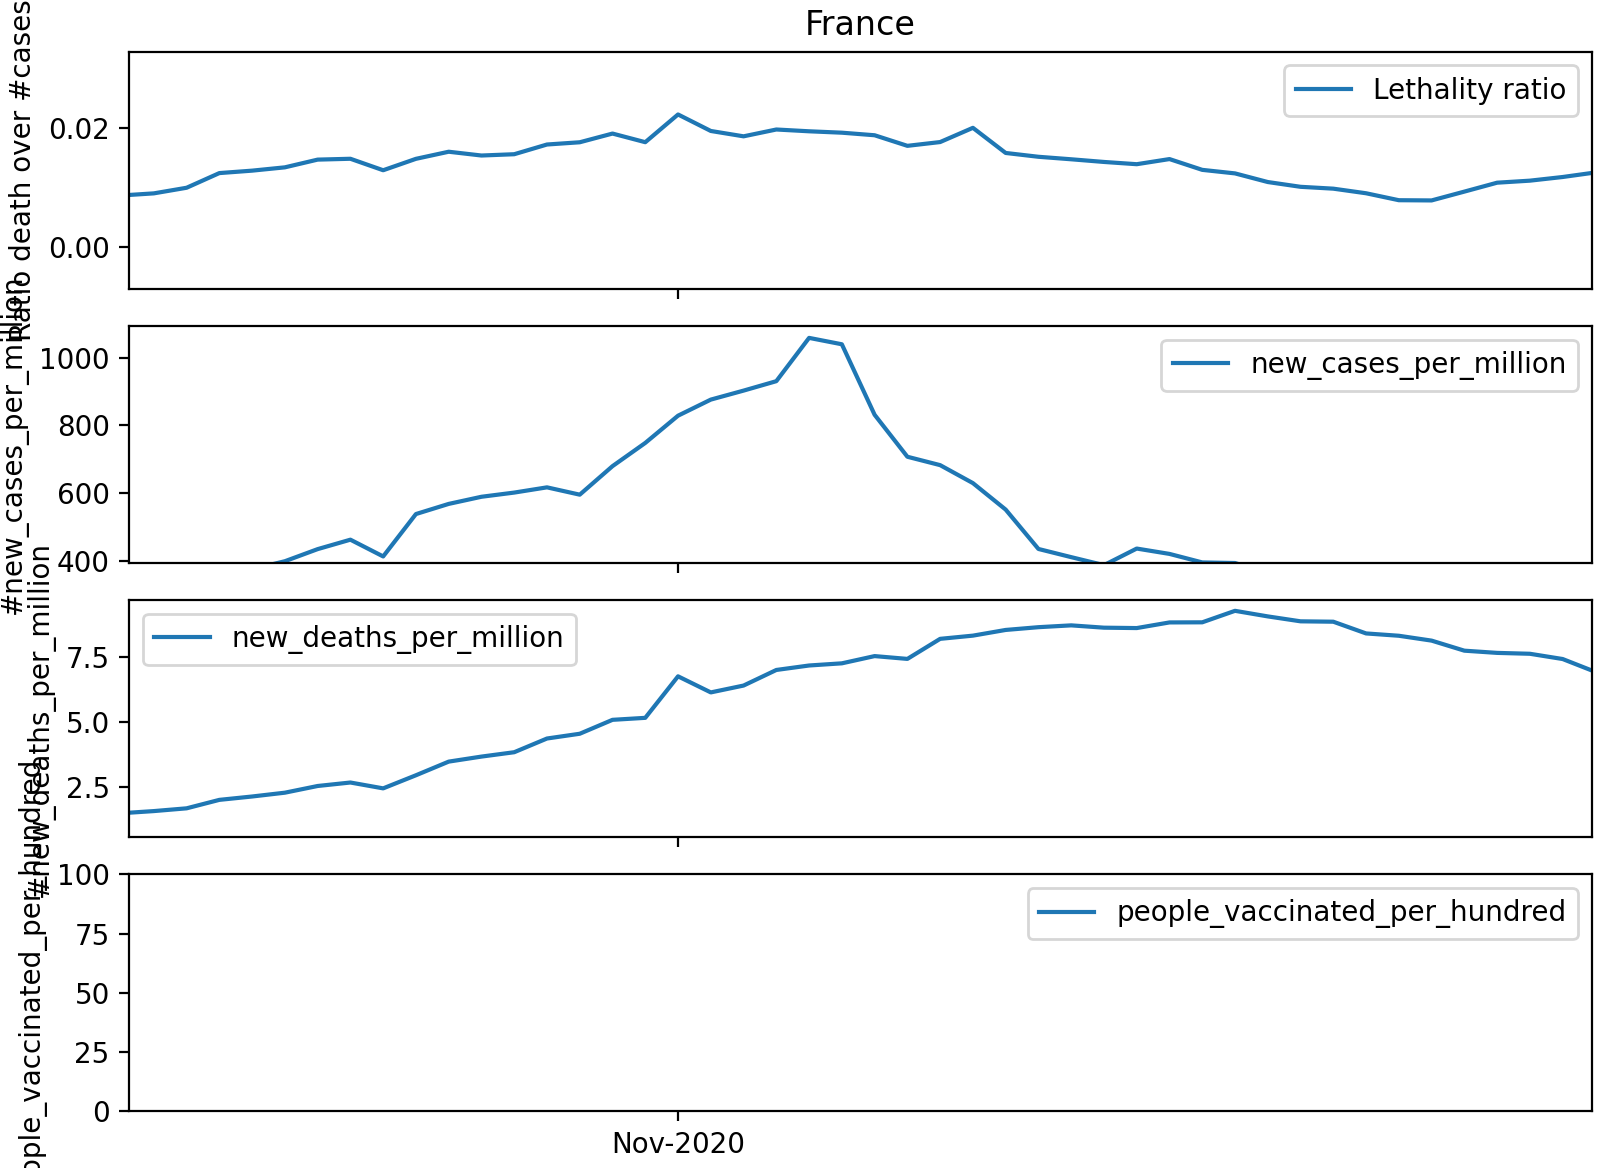

In [11]:
fig = get_lethality_rate(data, 
                         country='France',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2020-10-01', end='2020-12-31');
fig.savefig('out/FR-Nov-2020.pdf')

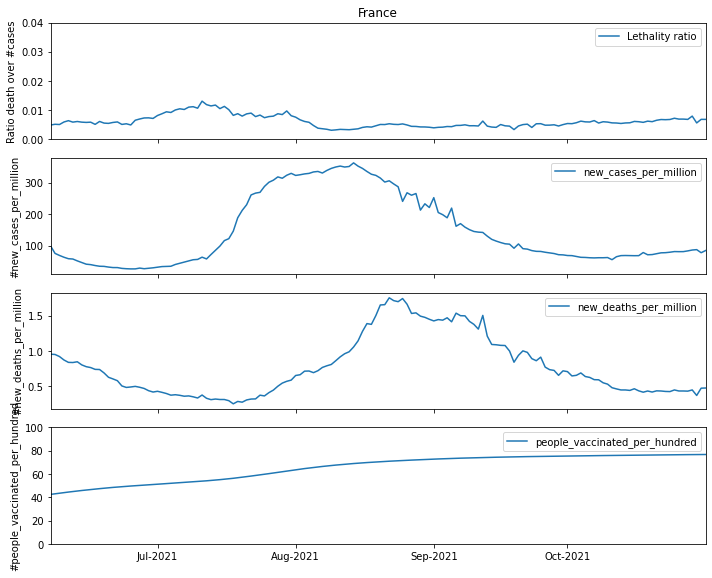

In [4]:
fig = get_lethality_rate(data, 
                         country='France',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-06-06', end='2021-10-31');
fig.savefig('out/FR-Aug-2021.pdf')

## Other example
In the following plot only the death ratio is plotted

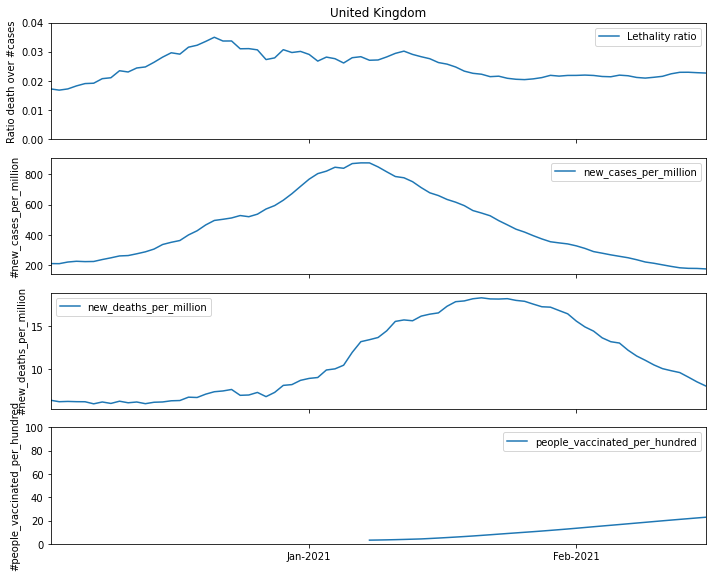

In [5]:
fig = get_lethality_rate(data, 
                         country='United Kingdom',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2020-12-01', end='2021-02-15');
fig.savefig('out/UK-Jan-2021.pdf')

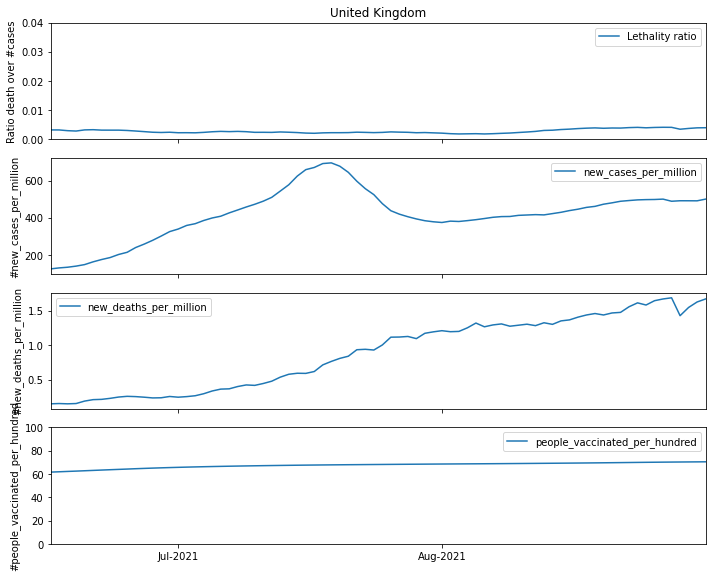

In [6]:
fig = get_lethality_rate(data, 
                         country='United Kingdom',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-06-15', end='2021-08-31');
fig.savefig('out/UK-Jul-2021.pdf')

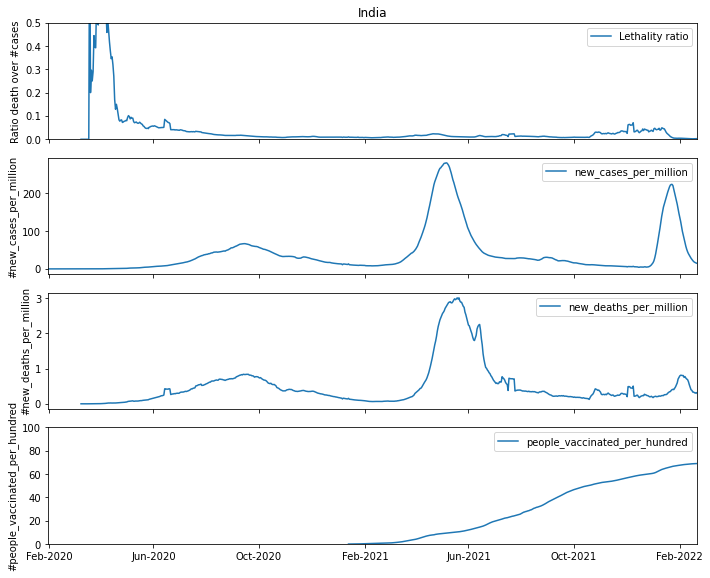

In [7]:
fig = get_lethality_rate(data, 
                         country='India',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start=None, end=None, ylim=(0, .5));
fig.savefig('out/India-whole.pdf')

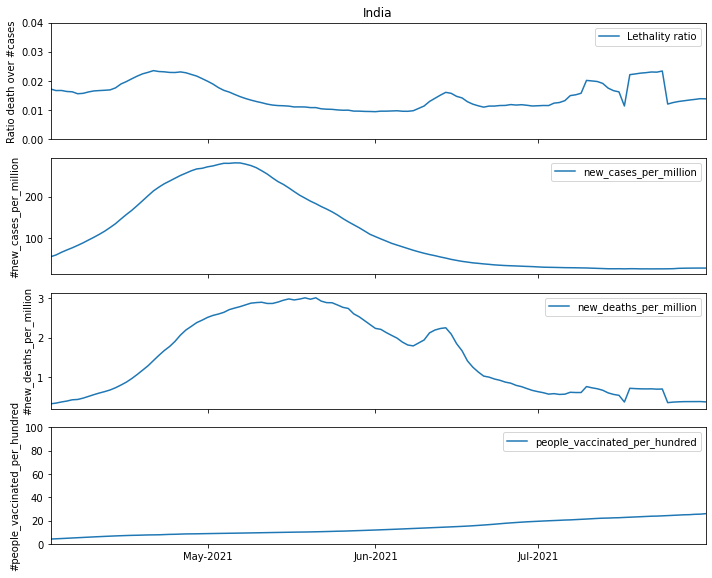

In [8]:
fig = get_lethality_rate(data, 
                         country='India',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-04-01', end='2021-07-31');
fig.savefig('out/India-Jun-2021.pdf')

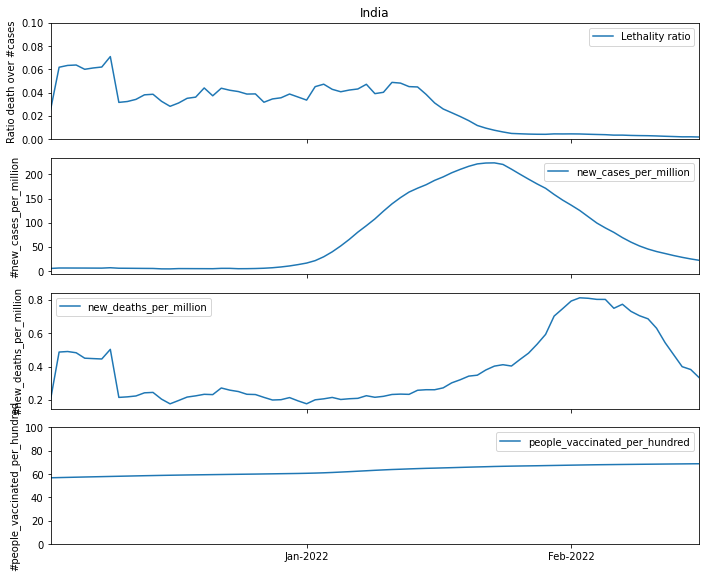

In [9]:
fig = get_lethality_rate(data, 
                         country='India',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-12-01', end='2022-02-15', ylim=(0, .1));
fig.savefig('out/India-Jun-2021.pdf')